بارگذاری داده‌ها و آماده‌سازی تاریخ

In [ ]:
import pandas as pd
import datetime as dt

try:
    df = pd.read_csv('dataset_Superstore.csv', encoding='windows-1252')
except:
    df = pd.read_csv('dataset_Superstore.csv', encoding='utf-8')

df['Order Date'] = pd.to_datetime(df['Order Date'])

print(df[['Order Date', 'Customer ID', 'Sales']].head())

  Order Date Customer ID  Sales
0 2017-11-13    MN-17935  8.904
1 2017-09-03    MY-18295  8.904
2 2017-10-30    JK-15205  7.420
3 2015-11-03    CS-12250  6.608
4 2016-04-08    JL-15505  8.260


C:\Users\Mohammad\AppData\Local\Temp\ipykernel_11352\1185408988.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Order Date'] = pd.to_datetime(df['Order Date'])


در محاسبه Recency (تازگی خرید)، ما نیاز داریم بدانیم "امروز" چه تاریخی است تا فاصله آخرین خرید مشتری را تا "امروز" بسنجیم. از آنجا که دیتاست Superstore قدیمی است (مثلاً تا سال ۲۰۱۴ یا ۲۰۱۷)، اگر تاریخ امروز واقعی سیستم را بگذاریم، Recency همه مشتریان عدد بزرگی می‌شود (مثلاً ۲۰۰۰ روز!).

بنابراین، ما فرض می‌کنیم "امروز" دقیقا یک روز بعد از آخرین خرید ثبت شده در کل دیتاست است.

In [ ]:
snapshot_date = df['Order Date'].max() + dt.timedelta(days=1)

print(f"تاریخ مبنا برای تحلیل: {snapshot_date}")

تاریخ مبنا برای تحلیل: 2017-12-31 00:00:00


محاسبه RFM
Recency: تعداد روزهای بین snapshot_date و آخرین Order Date مشتری.

Frequency: تعداد دفعات خرید (تعداد فاکتورهای یکتا).

Monetary: مجموع Sales مشتری.

In [ ]:
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days, # فرمول Recency
    'Order ID': 'nunique', # فرمول Frequency (شمارش تعداد سفارش‌های یکتا)
    'Sales': 'sum'          
})

rfm.rename(columns={
    'Order Date': 'Recency',
    'Order ID': 'Frequency',
    'Sales': 'Monetary'
}, inplace=True)

print(rfm.head())

             Recency  Frequency  Monetary
Customer ID                              
AA-10315         185          5  5563.560
AA-10375          20          9  1056.390
AA-10480         260          4  1790.512
AA-10645          56          6  5086.935
AB-10015         416          3   886.156


In [ ]:
بررسی توزیع داده‌ها

In [ ]:
print(rfm.describe())

           Recency   Frequency      Monetary
count   793.000000  793.000000    793.000000
mean    147.802018    6.316520   2896.848500
std     186.211051    2.550885   2628.670117
min       1.000000    1.000000      4.833000
25%      31.000000    5.000000   1146.050000
50%      76.000000    6.000000   2256.394000
75%     184.000000    8.000000   3785.276000
max    1166.000000   17.000000  25043.050000


رفع کجی داده‌ها (Unskewing): تبدیل داده‌ها به توزیع نرمال‌تر با لگاریتم.

هم‌مقیادس‌سازی (Scaling): استاندارد کردن اعداد تا همه در یک رنج باشند.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

rfm_log = np.log(rfm[['Recency', 'Frequency', 'Monetary']])

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

print("داده‌ها نرمال و اسکیل شدند:")
print(rfm_scaled.head())

داده‌ها نرمال و اسکیل شدند:
              Recency  Frequency  Monetary
Customer ID                               
AA-10315     0.722831  -0.289781  1.010429
AA-10375    -0.976638   0.952966 -0.565245
AA-10480     0.982818  -0.761570 -0.064821
AA-10645    -0.190075   0.095698  0.925487
AB-10015     1.341871  -1.369811 -0.731900


پیدا کردن تعداد بهینه خوشه‌ها (Elbow Method)

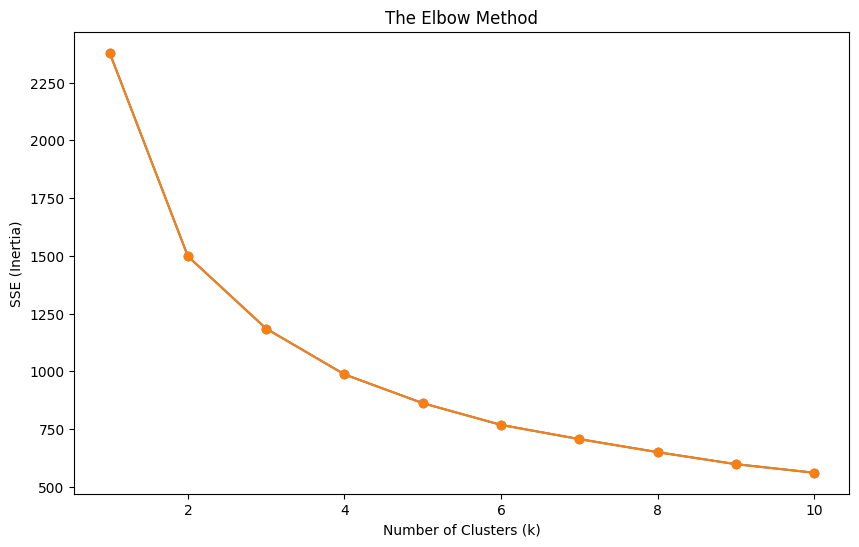

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {} # Sum of Squared Errors

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42) # random_state برای تکرارپذیری نتایج
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_ # این معیار خطاست (هرچه کمتر، بهتر)

plt.figure(figsize=(10, 6))
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.savefig('elbow_plot.png') # نمودار را مستقیماً ذخیره می‌کند
#plt.show()

مدل نهایی را با K=3 بسازیم.

برچسب خوشه‌ها را به دیتای اصلی اضافه کنیم.

میانگین هر گروه را بگیریم تا بفهمیم "خوشه ۱" چه کسانی هستند (پولدارها؟ یا کسانی که قهر کرده‌اند؟)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)
rfm['Cluster'] = kmeans.labels_


rfm_metrics = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)

rfm_counts = rfm.groupby('Cluster')['Recency'].count().rename('Customer Count')

cluster_summary = rfm_metrics.join(rfm_counts)

print("--- خلاصه رفتار خوشه‌های مشتریان (K=3) ---")
print("ستون 'Customer Count' نشان‌دهنده تعداد مشتریان در آن خوشه است.")
print(cluster_summary.to_markdown())

--- خلاصه رفتار خوشه‌های مشتریان (K=3) ---
ستون 'Customer Count' نشان‌دهنده تعداد مشتریان در آن خوشه است.
|   Cluster |   Recency |   Frequency |   Monetary |   Customer Count |
|----------:|----------:|------------:|-----------:|-----------------:|
|         0 |     183.7 |         6.4 |     3184.4 |              366 |
|         1 |     290.9 |         3.1 |      622.9 |              146 |
|         2 |      26.7 |         7.9 |     3703.8 |              281 |
